# SPOTPY - calibración
***
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __6/12/2019__ <br>

__Introducción__<br>
Se dcalibra el modelo de nieve de la cuenca alta del Deva mediante el algoritmo de optimización SCEUA.

* Los parámetros a calibrar en el modelo se definen en el  archivo _parametros.yml_.

__Cosas a mejorar__ <br>

__Índice__ <br>

***

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
from netCDF4 import Dataset
from datetime import date, datetime, timedelta
import geopandas as gpd
from calendar import monthrange

In [2]:
rutaBase = os.getcwd()

In [3]:
os.chdir(os.path.join(rutaBase, '../../../py'))
from funciones_modelo_nieve import *
from funciones_raster import *
from funciones_rendimiento_espacial import *
os.chdir(rutaBase)

In [4]:
os.chdir(os.path.join(rutaBase, '../../../../MODIS/py'))
from funciones_MODIS import *
os.chdir(rutaBase)

os.chdir(os.path.join(rutaBase, '../'))
%run funciones_raster.ipynb
%run funciones_modelo_nieve.ipynb
%run class_MODIS.ipynb
os.chdir(rutaBase)

## 1. Datos
### 1.1 Cartografía

In [5]:
# ruta cartografía
rutaGIS = os.path.join(rutaBase, '../../../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

### 1.2 Nieve MODIS

In [6]:
# Cargar netCDF con los datos climáticos
rutaMODIS = os.path.join(rutaBase, '../../data/')
nc = Dataset(rutaMODIS + 'MODIS_Maximum_Snow_Extent_Terra+Aqua.nc', 'r', format='NETCDF4')

# extraer datos
data = nc['SC'][::]
units = nc['SC'].units
# fechas
times = np.array([datetime(1, 1, 1).date() + timedelta(time) for time in nc['time'][:].data])
# coordenadas
X = nc['X'][:].data
Y = nc['Y'][:].data
crs = CRS.from_epsg(nc.coordinateSystem.split(':')[1])

# guardar como objeto raster3D
SCobs = raster3D(data, X, Y, times, variable='snow cover', label='SC', units=units,
                   crs=crs)

nc.close()

### 1.3 Precipitación y temperatura

In [7]:
# Cargar netCDF con los datos climáticos
rutaClima = os.path.join(rutaBase, '../../../data/clima/')
nc = Dataset(rutaClima + 'clima_1265.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = np.array([date(1979, 1, 1) + timedelta(days=int(d)) for d in dates])
pcp = nc['pcp'][::].data
tmp = nc['tmp'][::].data

nc.close()

In [8]:
# guardar como objetos raster3D
PCP = raster3D(pcp, X, Y, dates, units='mm', variable='Precipitación', label='P',
            crs=CRS.from_epsg(25830))

TMP = raster3D(tmp, X, Y, dates, units='°C', variable='Temperatura', label='T',
            crs=CRS.from_epsg(25830))

In [9]:
# enmascarar celdas sin ningún dato
PCP.enmascararNaN()
TMP.enmascararNaN()

### 1.4 Radiación

In [10]:
rad = np.zeros((12, *DEM.data.shape)) * np.nan
for i in range(1, 7):
    asci = read_ascii(rutaClima + 'rad{0:02d}.asc'.format(i))
    radi = asci.data
    if i == 1:
        # arrays de coorenadas
        ncols, nrows, xll, yll, cs, noDATA = asci.attributes
        Xrad = np.arange(xll, xll + cs *ncols, cs)
        Yrad = np.arange(yll, yll + cs *nrows, cs)[::-1]
        # recortar filas y columnas sin dato
        radi, Xrad, Yrad = corregirRaster(radi, Xrad, Yrad)
    else:
        # recortar filas y columnas sin dato
        radi = corregirRaster(radi)
    # asignar mapa
    rad[i-1,:,:] = radi.copy()
    rad[12-i,:,:] = radi.copy()

In [11]:
# guardar como objeto raster3D
RAD = raster3D(rad, Xrad, Yrad, np.arange(1, 13), variable='radiación', units='-',
               label='Rad', crs=CRS.from_epsg(25830))
RAD.enmascararNaN()

## 2. Calibración 

In [12]:
%run spotpy_setup.ipynb

### 2.1 Periodos de calibración y validación

In [13]:
# periodo de calibración
startC = datetime(2005, 10, 1).date()
endC = datetime(2010, 9, 30).date()
# periodo de validación
startV = datetime(2010, 10, 1).date()
endV = datetime(2015, 9, 30).date()

In [14]:
# recortar los datos climáticos a los periodos de calibración y validación
PCPcal = PCP.extraer(startC, endC, axis=0, inplace=False)
PCPval = PCP.extraer(startV, endV, axis=0, inplace=False)
TMPcal = TMP.extraer(startC, endC, axis=0, inplace=False)
TMPval = TMP.extraer(startV, endV, axis=0, inplace=False)

In [15]:
# recortar datos MODIS
times = SCobs.times
i = np.where(times == endC)[0][0]
SCobsC = SCobs.extraer(times[0], times[i], axis=0, inplace=False)
SCobsV = SCobs.extraer(times[i+1], times[-1], axis=0, inplace=False)

### 2.1 Lanzar calibración

In [16]:
# importar parámetros a calibrar
with open("parametros.yml", "r") as ymlfile:
    pars = yaml.load(ymlfile, Loader=yaml.FullLoader)
pars

{'Tb': {'min': -2, 'max': 6, 'ini': 0},
 'DDF1': {'min': 0, 'max': 6, 'ini': 3},
 'DDF2': {'min': 0, 'max': 10, 'ini': 5}}

In [17]:
rutaOut = os.path.join(rutaBase, '../../output/')

In [18]:
setup = spotpy_setup(PCPcal, TMPcal, SCobsC, pars, RAD=RAD, obj_func=rendimiento_clasificacion)
sampler = spotpy.algorithms.sceua(setup, dbname=rutaOut + 'SCEUA_DDM', dbformat='csv')
#Select number of maximum repetitions
rep = 1000
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'C:\Users\jcr693\Documents\GitHub\Calibrar\Nieve\notebooks\spotpy\../../output/SCEUA_DDM.csv' created.
2 of 1000, minimal objective function=0.123725, time remaining: 00:24:19
4 of 1000, minimal objective function=0.123725, time remaining: 00:27:48
5 of 1000, minimal objective function=0.123725, time remaining: 00:29:44
6 of 1000, minimal objective function=0.123725, time remaining: 00:30:42
7 of 1000, minimal objective function=0.123725, time remaining: 00:31:16
8 of 1000, minimal objective function=0.123725, time remaining: 00:31:37
9 of 1000, minimal objective function=0.123725, time remaining: 00:31:45
10 of 1000, minimal objective function=0.122795, time remaining: 00:32:05
11 of 1000, minimal objective function=0.122795, time remaining:

KeyboardInterrupt: 

### 2.2 Resultados de la calibración

In [19]:
# importar resultados
sceua = pd.read_csv(rutaOut + 'SCEUA_DDM.csv', usecols=range(4))
sceua.columns = ['f1'] + [col[3:] for col in sceua.columns[1:]]
sceua.shape

(196, 4)

No entiendo por qué a pesar de definir 1000 iteraciones, en el archivo de salida de la calibración sólo se guardan 196.

In [20]:
# extraer mejor rendimiento y sus parámetros asociados
best_idx = sceua.f1.idxmin()
best_pars = sceua.loc[best_idx].iloc[1:]
best_OF = sceua.f1.min()
print('f1 = {0:.3f}'.format(best_OF))
for par in best_pars.index:
    print('{0} = {1:.3f}'.format(par, best_pars[par]), end='\t')

f1 = 0.122
Tb = 4.800	DDF1 = 4.715	DDF2 = 8.820	

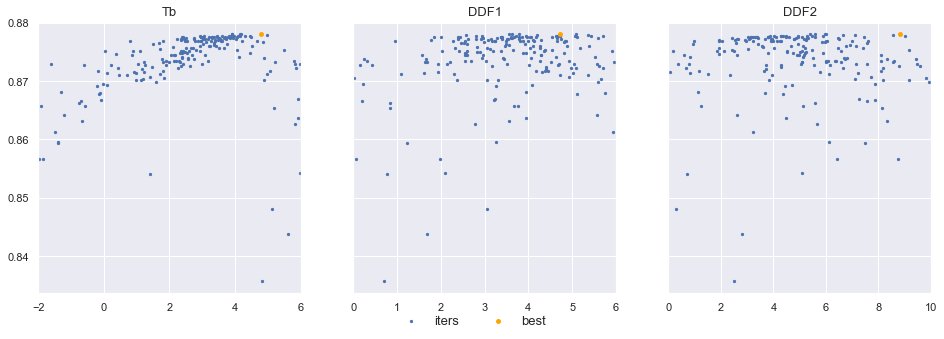

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)

for ax, par in zip(axes.flatten(), pars):
    ax.scatter(sceua[par], 1 - sceua.f1, s=5, label='iters')
    ax.scatter(best_pars[par], 1 - best_OF, c='orange', s=15, label='best')
    ax.set_xlim(pars[par]['min'], pars[par]['max'])
    ax.set_title(par, fontsize=13)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=8, ncol=2, fontsize=13);

plt.savefig(rutaOut + 'Sensibilidad parámetros.png', dpi=600, bbox_inches='tight');

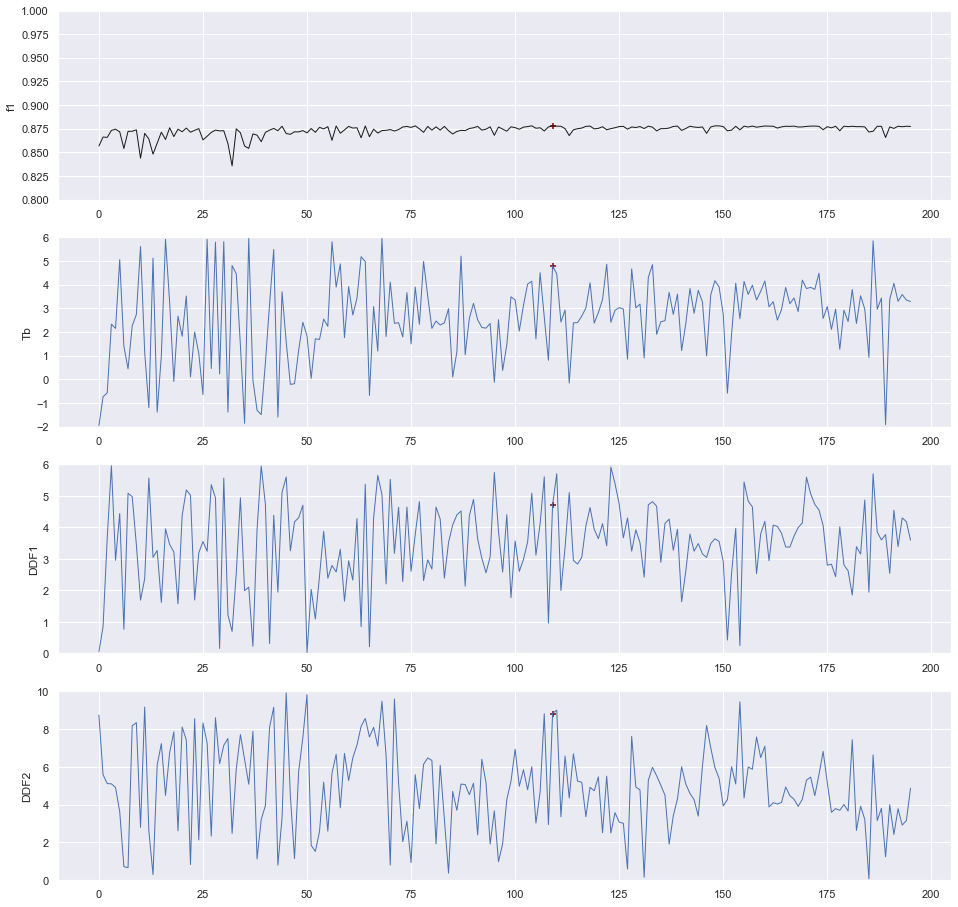

In [23]:
# gráficos de la evolución de la calibración
fig, axes = plt.subplots(nrows=4, figsize=(16, 16))

axes[0].plot(1 - sceua.f1, c='k', lw=1)
axes[0].scatter(best_idx, 1 - best_OF, marker='+', color='maroon')
axes[0].set(ylabel='f1', ylim=(0.8, 1))
for ax,  par in zip(axes[1:], pars):
    ax.plot(sceua[par], lw=1)
    ax.scatter(best_idx, sceua.loc[best_idx, par], marker='+', color='maroon')
    ax.set(ylabel=par, ylim=(pars[par]['min'], pars[par]['max']))

    plt.savefig(rutaOut + 'Evolución calibración.png', dpi=600, bbox_inches='tight');

## 3 Simulación

In [24]:
# calcular modelo de nieve
SWE, SM = degreeDayMethod(PCPval, TMPval, RAD=RAD, Ts=0., Tb=best_pars['Tb'],
                                DDF1=best_pars['DDF1'], DDF2=best_pars['DDF2'],
                                verbose=True)

# reclasificar SWE en un mapa binario
SCsim = snowCover(SWE, threshold=1)

# agregar simulación a paso 8 días
SCsim8 = remuestrearMODIS(SCobsV, SCsim, func='max')
SWEsim8 = remuestrearMODIS(SCobsV, SWE, func='max')

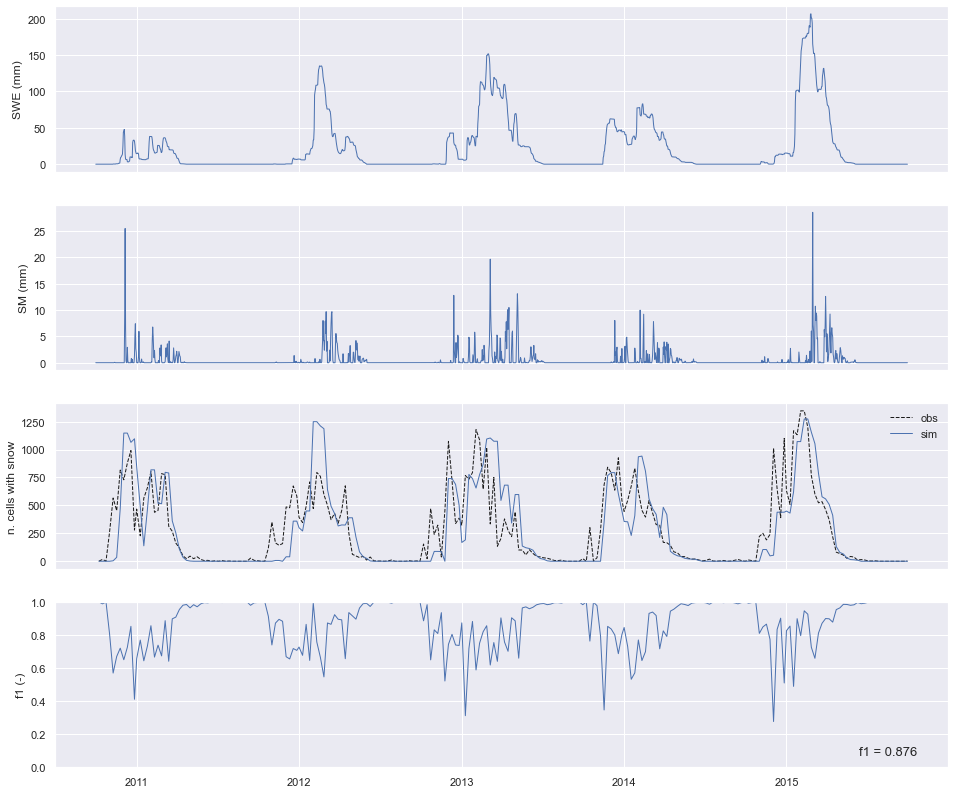

In [25]:
fig, ax = plt.subplots(nrows=4, figsize=(16, 14), sharex=True, sharey=False)

# serie de equivalente agua-nieve
serieSWE = pd.Series(np.nanmean(SWE.data, axis=(1,2)), index=SWE.times)
ax[0].plot(serieSWE, lw=1)
ax[0].set_ylabel('SWE (mm)')

# serie de fusión
serieSM = pd.Series(np.nanmean(SM.data, axis=(1,2)), index=SM.times)
ax[1].plot(serieSM, lw=1)
ax[1].set_ylabel('SM (mm)')

# series de nº de celdas nevadas
cellsObs = pd.Series(np.nansum(SCobsV.data, axis=(1, 2)).data, index=SCobsV.times)
cellsSim = pd.Series(np.nansum(SCsim8.data, axis=(1, 2)).data, index=SCsim8.times)
ax[2].plot(cellsObs, ls='--', c='k', lw=1, label='obs')
ax[2].plot(cellsSim, lw=1, label='sim')
ax[2].set_ylabel('n. cells with snow')
ax[2].legend();

# serie de rendimiento en f1
f1Serie = rendimiento_clasificacion(SCobsV, SCsim8, score='f1')
f1Mean = f1Serie.mean()
ax[3].plot(f1Serie, lw=1)
ax[3].set(ylabel='f1 (-)', ylim=(0, 1))
ax[3].text(0.9, 0.075, 'f1 = {0:.3f}'.format(f1Mean), fontsize=13, transform=ax[3].transAxes);

plt.savefig(rutaOut + 'Resultados_validación.png', dpi=600, bbox_inches='tight');

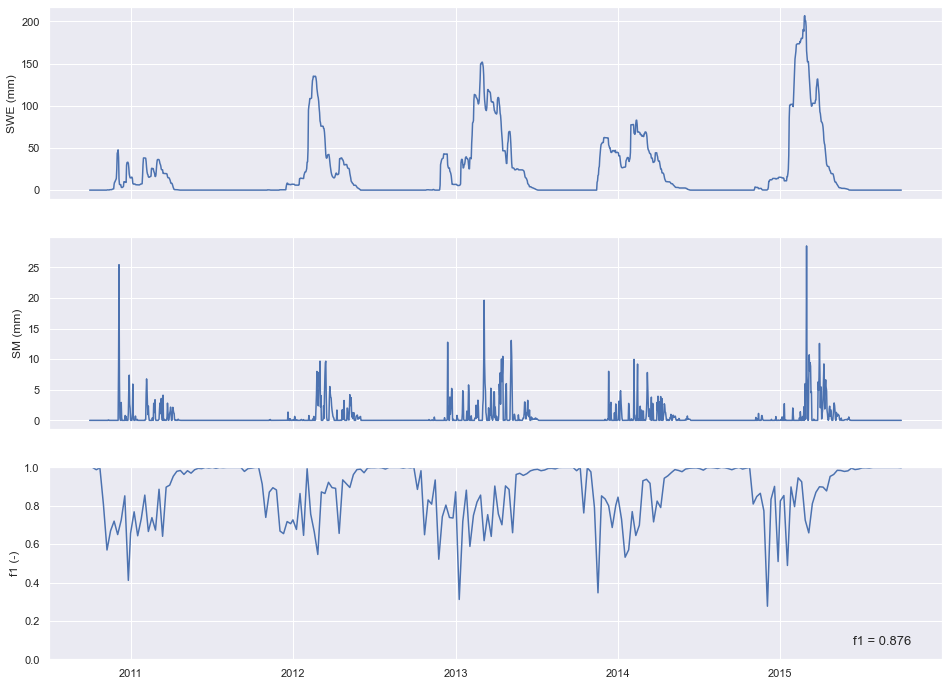

In [26]:
# serie de resultados
serieSWE = pd.Series(np.nanmean(SWE.data, axis=(1,2)), index=SWE.times)
serieSM = pd.Series(np.nanmean(SM.data, axis=(1,2)), index=SM.times)

fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True, sharey=False)
# series simuladas: snow-water equivalent, snowmelt
for ax, serie, label in zip(axes[:2], [serieSWE, serieSM], ['SWE', 'SM']):
    ax.plot(serie)
    ax.set_ylabel(label + ' (mm)')
# serie de rendimiento
axes[2].plot(f1Serie)
axes[2].set(ylabel='f1 (-)', ylim=(0, 1))
axes[2].text(0.9, 0.075, 'f1 = {0:.3f}'.format(f1Mean), fontsize=13, transform=axes[2].transAxes);
plt.savefig(rutaOut + 'Resultados_validación.png', dpi=600, bbox_inches='tight');

In [27]:
# definir colores
colors = np.array([[255, 255, 255 , 0], [33, 178, 171, 130]])
colors = colors / 255.
cmap_snow = ListedColormap(colors)
boundaries = [0, .5, 1]
norm = BoundaryNorm(boundaries, cmap_snow.N, clip=True)
snow_patch = mpatches.Patch(color=cmap_snow.colors[1], label='snow')

In [28]:
# definir límites del mapa
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= DEM.cellsize * 2
ymin -= DEM.cellsize * 2
xmax += DEM.cellsize * 2
ymax += DEM.cellsize * 2
extent = [xmin, xmax, ymin, ymax]

2011-01-09


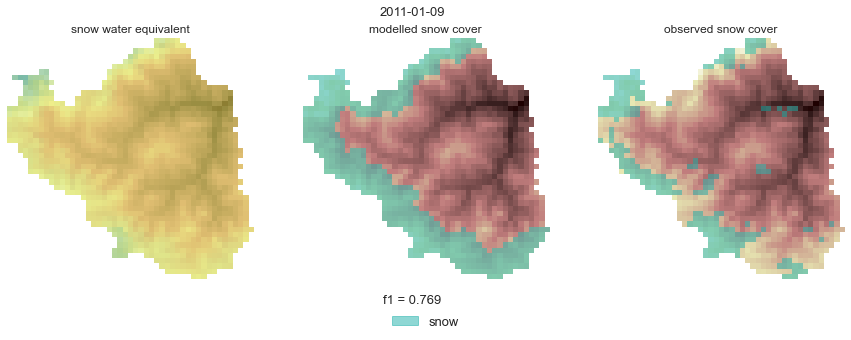

In [29]:
t = 12
time = SCobsV.times[t]
print(time)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

SCobsV.variable = 'observed snow cover'
for i, (ax, Var) in enumerate(zip(axes, [SWEsim8, SCsim8, SCobsV])):
    ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    if i == 0:
        ax.imshow(Var.data[t,:,:], extent=Var.extent(), cmap='summer_r', alpha=.5)
    else:
        ax.imshow(Var.data[t,:,:], extent=Var.extent(), cmap=cmap_snow, norm=norm)
    ax.set_title(Var.variable)
    ax.axis('off')
fig.text(0.5, 0.9, time, horizontalalignment='center', fontsize=13)
fig.text(0.5, .1, 'f1 = {0:.3f}'.format(f1Serie[time]), horizontalalignment='center', fontsize=13)
fig.legend(handles=[snow_patch], loc=8, fontsize=13);
plt.savefig(rutaOut + 'Mapas_validación.png', dpi=600, bbox_inches='tight');

Exportando archivo C:\Users\jcr693\Documents\GitHub\Calibrar\Nieve\notebooks\spotpy\../../output/SC_simulado_vs_observado_(calib).mp4


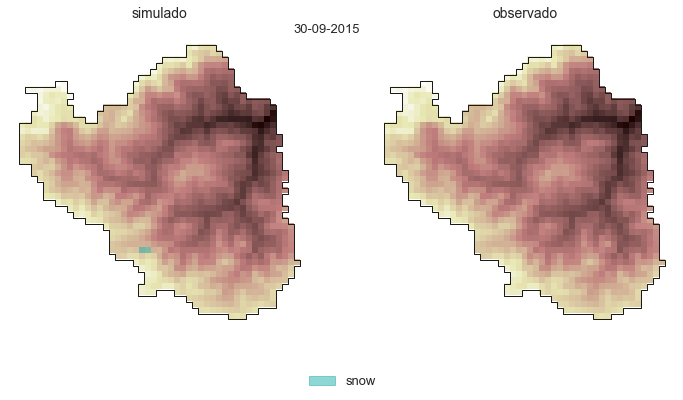

In [30]:
# vídeo simulado vs observado
mp4File = rutaOut + 'SC_simulado_vs_observado_(calib).mp4'
video2(SCobsV, SCsim8, cuenca, cmap_snow, norm, DEM, fps=3, dpi=300, figsize=(12, 6),
       extent=extent, labels=['simulado', 'observado'], export=mp4File)